<a href="https://colab.research.google.com/github/Tyanakai/religious_art/blob/main/religious_art_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>宗教画テーマの分類　訓練</h1>




# 1.はじめに
本ノートブックの目的は、ProbSpace上で開催された[宗教画テーマの分類](https://comp.probspace.com/competitions/religious_art)のタスクに基づいて、<br>
公開されている事前学習されたモデルを訓練し、保存することです。<br>
使用するモデルは以下の通りです。

*   [EfficientNet-B4, EfficientNet-B7](https://github.com/qubvel/efficientnet)
*   [EfficientNetV2-S](https://github.com/google/automl/tree/master/efficientnetv2)

尚、colabratory上で、ランタイムのタイプをTPUに設定した状態での実行を想定しています。

# 2.事前に完了していること
*    [religious_art_eda.ipynb](https://github.com/Tyanakai/religious_art/blob/main/religious_art_eda.ipynb)の実行
*    上で保存した画像をGoogle Cloud Storageにアップロード

<br>
今回の訓練では、Google Cloud Storageに保存した画像(jpg形式)を使用して訓練します。<br>
事前にreligious_art_eda.ipynbを実行し、保存した(train_image, test_image)フォルダをGoogle Cloud Storageにアップロードしておきます。

# 3.環境準備
訓練環境を構築します。

## 3.1ライブラリ

In [ ]:
!pip install -q tensorflow-addons
!pip install -q efficientnet

import datetime
import json
import os
import sys

import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow_hub as hub

     |████████████████████████████████| 1.1 MB 5.4 MB/s 
     |████████████████████████████████| 50 kB 2.6 MB/s 


## 3.2 Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 3.3 Google Cloud Storage
Google Cloud Storageとの接続の為に、ユーザー認証します。

In [ ]:
from google.colab import auth
auth.authenticate_user()

## 3.4 TPU
TPU使用の為の設定を行います。今回はcloud上のデータに対しTPUを使用します。

In [ ]:
project_id = 'Google Cloudのproject id'
!gcloud config set project {project_id}
!gsutil ls

try:
    tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
except:
    TPU = None
    print('INFO: Not connected to a TPU runtime')

AUTOTUNE = tf.data.experimental.AUTOTUNE

Updated property [core/project].
gs://colab_test2/


## 3.5 ハイパーパラメータ設定

主なパラメーターの説明は下記の通りです。

|パラメータ名|説明|
|:-|:-|
|model|使用する事前学習されたモデル名|
|weights|事前学習のタイプ efnの場合'noisy-student', efn-v2の場合'imagenet21k-ft1k'|
|-|-|
|original_size|画像の原寸。正方形の一辺の長さ|
|image_size|tf.data.Dataset形式に変換する際の画像サイズ|
|patience|EarlyStoppingのパラメータ。訓練早期終了を延期するepoch数|
|stop_monitor|arlyStoppingのパラメータ。訓練早期終了を判定する指標|
|best_monitor|ModelCheckpointのパラメータ。保存するmodelの選定指標|
|-|-|
|num_ops|random augmentを行う際、一度の拡張で適用する手法の数| 
|magnitude|random augmentを行う際、適用する拡張手法の度合|
|-|-|
|lr_base|学習率の初期値|
|lr_max|学習率の最大値|
|lr_min|学習率の最小値|
|begining|訓練初期段階で、学習率をlr_baseからlr_maxまで引き上げるまでのepoch数|
|ending|学習率がlr_baseに再降下するepoch数|
|-|-|
|pseudo|準備した擬似ラベルを訓練に使用するか|
|exclusive|重複画像を除いたデータを訓練に使用するか|
|copy|個数の少ないクラスの訓練データを複製するか|
|copy_classes|複製対象とするクラス|
|copy_rate|複製の割合。dup_rate=0:対象データを全て複製、dup_rate=1:複製しない|

In [ ]:
class Config:
    model = "efn_b7"  #@param ["efn_b4","efn_b7","efficientnetv2-s"]
    weights = 'noisy-student' #@param ['noisy-student','imagenet21k-ft1k']
    base_batch_size = 2 #@param {type:"raw"} [1,2,4,8,16]
    batch_size = base_batch_size * 8
    epochs = 100 #@param {type:"raw"}
    n_folds = 5
    seed = 21 #@param

    original_size = 224
    # v2-s:384, v2-m:480
    image_size = 600    #@param {type:"raw"} [224,240,260,300,380,456,528,600,384,480]
    n_classes = 13
    patience =  20 #@param
    stop_monitor= "val_loss" #@param ["val_loss", "val_accuracy"]
    best_monitor = "val_accuracy" #@param ["val_loss", "val_accuracy"]

    num_ops = 10 #@param {type:"slider", min:0, max:15, step:1}
    magnitude = 5 #@param {type:"slider", min:0, max:10, step:1}

    lr_base = 1e-5
    lr_max = 7 * 1e-4
    lr_min = 1e-10
    begining = 10
    ending = 70

    pseudo = False #@param {"type":"boolean"}
    pseudo_file = "pseudo_soft.csv" #@param
    exclusive = True #@param {"type":"boolean"}
    copy = True #@param {"type":"boolean"}
    copy_classes = [7, 8, 10, 12] #@param
    copy_rate = 0.7

    debug = True #@param {"type":"boolean"}

if Config.debug:
    Config.epochs = 2
    Config.n_folds = 2



## 3.6 path
pathを設定しfolderを作成します。

In [ ]:
DRIVE = "/content/drive/MyDrive/portforio/religious_art"
GS = "gs://colab_test2/" # Google Cloud Storage 

INPUT = os.path.join(DRIVE, "input")
OUTPUT = os.path.join(DRIVE, "output")
MODEL = os.path.join(DRIVE, "model", f"{Config.model}-{Config.image_size}")
RECORD = os.path.join(DRIVE, "model", "record")
SUBMIT = os.path.join(DRIVE, "submit")
PROB = os.path.join(DRIVE, "prob") # 予測確率値(probability)を保存するフォルダ

GS_TRAIN = os.path.join(GS, "train_image")
GS_TEST = os.path.join(GS, "test_image")

DRIVE_TRAIN = os.path.join(INPUT, "train_image")

for folder in [INPUT, OUTPUT, MODEL, RECORD, SUBMIT, PROB]:
    os.makedirs(folder, exist_ok=True)

# efficientnet-v2のdownload元
weights_dic = {"imagenet21k-ft1k":"21k-ft1k","imagenet21k":"21k"}
hub_url = ('gs://cloud-tpu-checkpoints/efficientnet/v2/hub'
           f'/{Config.model}-{weights_dic.get(Config.weights,None)}/feature-vector')

# 4.データ準備
データを処理し、tf.data.Datasetとして取得するための関数やクラスを定義します。

## 4.1 取得

In [ ]:
def get_train_data():
    """
    訓練データのfilepathのリストと訓練ラベルを取得する。
    """
    labels = np.load(
        os.path.join(INPUT, "christ-train-labels.npz"))["arr_0"]
    labels = pd.get_dummies(labels).values.astype(np.float32)
    labels = smooth_label(labels)

    file_idx = np.arange(labels.shape[0])
    if Config.exclusive:
        file_idx = make_exclusive(file_idx)

    filepaths = np.array(
        [GS_TRAIN + f"/train_img{i:0>3d}.jpg" for i in file_idx])
          
    return filepaths, labels[file_idx]


def get_test_data():
    test_imgs = np.load(
        os.path.join(INPUT, "christ-test-imgs.npz"))["arr_0"]
    file_idx = np.arange(test_imgs.shape[0])
    filepaths = np.array(
        [GS_TEST + f"/test_img{i:0>3d}.jpg" for i in file_idx])
    
    return filepaths


def concat_pseudo(filepaths, labels):
    """
    擬似ラベルを取得、連結し、ファイルパスを上書きする。
    """
    pseudo_file = pd.read_csv(os.path.join(OUTPUT, Config.pseudo_file), 
                              index_col=0)
    pseudo_idx = pseudo_file.index.value
    if Config.exclusive:
        pseudo_idx = make_exclusive(pseudo_idx)

    labels = np.concatenate([labels, pseudo_file.values], axis=0).astype(np.float32)

    pse_filepaths = np.array(
        [GS_TEST + f"/test_img{i:0>3d}.jpg" for i in pseudo_idx])
    filepaths = np.concat([filepaths, pse_filepaths], axis=0)
    
    return filepaths, labels

## 4.2 加工

In [ ]:
def smooth_label(label, factor=0.1):
    """
    label smoothingを適用する。
    """
    labels = np.array((1 - factor) * label + (factor / label.shape[1]))
    return labels.astype(np.float32)

In [ ]:
def make_exclusive(index_list):
    """
    index_listからdup_idxにあるindexを取り除く
    """
    dup_idx = np.load(os.path.join(OUTPUT, "dup_idx.npy"))
    exclusive_idx_set = set(idx for idx in index_list) - set(dup_idx)
    return np.array(list(exclusive_idx_set))

In [ ]:
def copy_few_data(ids, labels):
    """
    個数の少ないクラスのindexを確率的に複製する。
    """
    class_labels = np.argmax(labels, axis=1)
    copy_ids = []
    for idx in ids:
        rn = np.random.uniform()       
        if class_labels[idx] in Config.copy_classes and rn > Config.copy_rate:
            copy_ids += [idx, idx]
        else:
            copy_ids.append(idx)
    return np.array(copy_ids)

In [ ]:
 def skf(x_train, y_train, n_folds=Config.n_folds, random_state=Config.seed):
     """
     訓練データを層化K分割し、リスト化したindexを取得する。
     """
     kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
     return list(kf.split(x_train, y_train))

## 4.3 tf.data.Dataset

In [ ]:
class ImageProcessor():
    """
    file pathを受け取り、画像を取得、拡張、tf.data.Dataset形式で出力

    Parameters
    --------------
        num_ops : int
            random augmentを行う際、適用する拡張手法の数
        magnitude : int
            random augmentを行う際、適用する拡張手法の度合
        image_size : int
            datasetの出力画像サイズ(＝訓練モデルの入力画像サイズ)
    """

    def __init__(self, num_ops, magnitude, image_size=Config.image_size):
        self.num_ops = num_ops
        self.magnitude = magnitude
        self.image_size = image_size

    def load_image(self, path, label=None):
        """
        file pathを受け取り、float32型のtensorを返す。
        """
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        return image, label

    def mix_up(self, ds1, ds2, alpha=0.2):
        """
        拡張法：2枚の画像とそのラベルをランダムな割合で合成する。
        """
        lam = tf.random.uniform(shape=[], maxval=0.11, dtype=tf.float32)
        image = tf.add(tf.multiply(ds1[0], (1 - lam)), tf.multiply(ds2[0], lam))
        label = tf.add(tf.multiply(ds1[1], (1 - lam)), tf.multiply(ds2[1], lam))
        return image, label

    def random_rotate(self, image, label=None):
        """
        拡張法：ランダムな角度(度数法)で画像を回転する。
        """
        level = np.pi * self.magnitude / 180 # 度数法を孤度法へ変換

        angle = tf.random.uniform(
            shape=[],minval=-level, maxval=level, dtype=tf.float32)
        image = tfa.image.rotate(
            image, angle, 
            fill_mode="nearest"
            )
        return image, label

    def random_cutout(self, image, label=None):
        """
        拡張法：画像のランダムな一部をに黒塗りにする。
        黒塗りは正方形となり、一辺の長さが偶数でなくてはならない。
        """
        mask = int(7 + 3 * self.magnitude) * 2
        image = tf.reshape(image, [1, Config.original_size, Config.original_size, 3])
        image = tfa.image.random_cutout(image, (mask, mask))
        return image[0], label

    def random_brightness(self, image, label=None):
        """
        拡張法：輝度をランダムに変化させる。
        """
        bright_delta = 0.05 * self.magnitude
        image = tf.image.random_brightness(image, bright_delta)
        return image, label

    def random_contrast(self, image, label=None):
        """
        拡張法：コントラストをランダムに変化させる。
        """
        lower = 0.8 - 0.06 * self.magnitude
        upper = 1.1 + 0.09 * self.magnitude
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        return image, label
    
    def random_saturation(self, image, label=None):
        """
        拡張法：彩度をランダムに変化させる。
        """
        lower = 0.8 - 0.079 * self.magnitude
        upper = 1.1 + 0.09 * self.magnitude
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        return image, label
    
    def random_hue(self, image, label=None):
        """
        拡張法：色相をランダムに変化させる。
        """
        hue_delta = 0.01 + 0.005 * self.magnitude #0819 0.004->0.005
        image = tf.image.random_hue(image, hue_delta)
        return image, label
       
    def random_flip(self, image, label=None):
        """
        拡張法：ランダムな割合で左右を反転する。
        """
        image = tf.image.random_flip_left_right(image)
        return image, label

    def random_zoom(self, image, label=None):
        """
        拡張法：ランダムな焦点にズームする。
        """
        zoom_rate = 0.05 + 0.035 * self.magnitude
        crop_size = tf.random.uniform(
            shape=[], 
            minval=int(Config.original_size*(1. - zoom_rate)), 
            maxval=Config.original_size, 
            dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
        image = tf.image.resize(image, size=[Config.original_size, Config.original_size])
        return image, label

    def random_sharpness(self, image, label=None):
        """
        拡張法：輪郭の強調感をランダムに変化させる。
        """
        factor = 0.01 + 0.089 * self.magnitude # 0819 0.009->0.089
        factor = tf.random.uniform([], minval=0, maxval=factor)
        image = tfa.image.sharpness(image, factor)
        return image, label

    def random_shear_x(self, image, label=None):
        """
        拡張法：ランダムに水平せん断写像を行う。
        """
        level = 0.02 + 0.015 * self.magnitude # 0819 0.018->0.015
        level = tf.random.uniform([], minval=-level, maxval=level)
        image = tfa.image.shear_x(image, level, [128,128,128])
        return image, label

    def random_shear_y(self, image, label=None):
        """
        拡張法：ランダムに鉛直せん断写像を行う。
        """
        level = 0.02 + 0.015 * self.magnitude # 0819 0.018->0.015
        level = tf.random.uniform([], minval=-level, maxval=level)
        image = tfa.image.shear_y(image, level, [128,128,128])
        return image, label

    def random_solarize_add(self, image, label=None):
        """
        拡張法：ランダムな露出効果を付加する。
        """
        addition = np.round(1 + 0.9 * self.magnitude)
        threshold = 1 + 3.1 * self.magnitude
        addition = tf.random.uniform([], minval=-addition, maxval=addition+1, dtype=tf.int64)
        threshold = tf.random.uniform([], minval=0, maxval=threshold)
        # tf.print("addition:", addition)
        # tf.print("threshold:", threshold)
        added_image = tf.add(tf.cast(image, tf.int64), addition)
        added_image = tf.cast(tf.clip_by_value(added_image, 0, 255), tf.float32)
        image = tf.where(image < threshold, added_image, image)
        return image, label

    def random_posterize(self, image, label=None):
        """
        拡張法：ランダムに色数を削減する。
        """
        shift = np.round(0.6 * self.magnitude)
        shift = tf.random.uniform([], minval=0, maxval=shift+1, dtype=tf.int32)
        # tf.print("shift:", shift)
        image = tf.cast(image, tf.int32)
        image =  tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)
        image = tf.cast(image, tf.float32)
        return image, label

    def identity(self, image, label=None):
        """
        恒等関数
        """
        return image, label

    def resize_divide_image(self, image, label=None):
        """
        モデルの入力形式に画像を調整する。
        """
        image = tf.image.resize(image, size=[self.image_size, self.image_size])
        image = tf.math.divide(image, 255)
        return image, label
        
    def augment_fns(self, ops, image, label=None):
        """
        上で定義した拡張法を数字で呼び出し、画像に施す。

        Parameters
        ------------
            ops : int
                呼び出す拡張法を指定する。
        """
        branch_fns = {
            0: lambda: self.random_zoom(image, label),
            1: lambda: self.random_shear_x(image, label),
            2: lambda: self.random_shear_y(image, label),
            3: lambda: self.random_brightness(image, label),
            4: lambda: self.random_contrast(image, label),
            5: lambda: self.random_saturation(image, label),
            6: lambda: self.random_hue(image, label),
            7: lambda: self.random_sharpness(image, label),
            8: lambda: self.random_flip(image, label),
            9: lambda: self.random_solarize_add(image, label),
            10: lambda: self.random_posterize(image, label),
            11: lambda: self.random_cutout(image, label),
            12: lambda: self.random_rotate(image, label)
        }
        image, label = tf.switch_case(
            ops, 
            branch_fns=branch_fns, 
            default=lambda: self.identity(image, label))
        return image, label

    def random_augment(self, image, label):
        """
        拡張法をself.num_ops回ランダムに呼び出し、画像に施す。
        """
        available_ops = ["zoom","shear_x","shear_y","flip",
                        "brightness","contrast","saturation","hue","sharpness",
                        "solarize_add","posterize","cutout","rotate"]
        ops = tf.random.uniform(
            [self.num_ops], maxval=len(available_ops), dtype=tf.int32)
        # tf.print("ops :", ops)
        for op in ops:
            image, label = self.augment_fns(op, image, label)

        return image, label

    def tr_dataset(self, file_path, label, batch_size=Config.batch_size, mix=True):
        """
        全ての拡張法を一度ずつ適用する。
        """
        num_files = file_path.shape[0]
        tr_ds = tf.data.Dataset.from_tensor_slices((file_path, label))
        tr_ds = tr_ds.map(self.load_image, num_parallel_calls=AUTOTUNE)
        # tr_ds = tr_ds.repeat()

        if mix:
            another_ds =tr_ds.shuffle(num_files)
            zip_ds = tf.data.Dataset.zip((tr_ds, another_ds))
            tr_ds = zip_ds.map(self.mix_up, num_parallel_calls=AUTOTUNE)

        tr_ds = tr_ds.shuffle(num_files)
        tr_ds = tr_ds.map(self.random_flip, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_shear_x, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_shear_y, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_zoom, num_parallel_calls=AUTOTUNE) 
        tr_ds = tr_ds.map(self.random_brightness, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_contrast, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_saturation, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_hue, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_sharpness, num_parallel_calls=AUTOTUNE)   
        tr_ds = tr_ds.map(self.random_solarize_add, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_posterize, num_parallel_calls=AUTOTUNE) 
        tr_ds = tr_ds.map(self.random_cutout, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.map(self.random_rotate, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.batch(batch_size)
        tr_ds = tr_ds.map(self.resize_divide_image, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.prefetch(buffer_size=AUTOTUNE)
        return tr_ds

    def val_dataset(self, file_path, label=None, batch_size=Config.batch_size):
        """
        validation用dataset
        """
        val_ds = tf.data.Dataset.from_tensor_slices((file_path, label))
        val_ds = val_ds.map(self.load_image, num_parallel_calls=AUTOTUNE)
        val_ds = val_ds.repeat()
        val_ds = val_ds.batch(batch_size)
        val_ds = val_ds.map(self.resize_divide_image, num_parallel_calls=AUTOTUNE)
        val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
        return val_ds

    def test_dataset(self, file_path, label=None, batch_size=Config.batch_size):
        """
        test用dataset
        """
        te_ds = tf.data.Dataset.from_tensor_slices((file_path, label))
        te_ds = te_ds.map(self.load_image, num_parallel_calls=AUTOTUNE)
        te_ds = te_ds.batch(batch_size)
        te_ds = te_ds.map(self.resize_divide_image, num_parallel_calls=AUTOTUNE)
        te_ds = te_ds.prefetch(buffer_size=AUTOTUNE)
        return te_ds

    def rand_aug_dataset(self, file_path, label, batch_size=Config.batch_size, mix=True):
        """
        random augmentを適用して、dataset化
        """
        num_files = file_path.shape[0]
        tr_ds = tf.data.Dataset.from_tensor_slices((file_path, label))
        tr_ds = tr_ds.map(self.load_image, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.repeat()

        if mix:
            another_ds =tr_ds.shuffle(num_files)
            zip_ds = tf.data.Dataset.zip((tr_ds, another_ds))
            tr_ds = zip_ds.map(self.mix_up, num_parallel_calls=AUTOTUNE)

        tr_ds.shuffle(num_files)
        tr_ds = tr_ds.map(self.random_augment, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.batch(batch_size)
        tr_ds = tr_ds.map(self.resize_divide_image, num_parallel_calls=AUTOTUNE)
        tr_ds = tr_ds.prefetch(buffer_size=AUTOTUNE)
        return tr_ds

# 5.訓練準備
訓練を補助する為の関数を定義します。


## 5.1 損失関数、最適化アルゴリズム
損失関数として、focal lossを使用します。<br>
また、epoch数によって学習率を出力する関数を定義します。

In [ ]:
def categorical_focal_loss(alpha, gamma=2.):
    """
    focal loss関数
    """
    alpha = np.array(alpha, dtype=np.float32)

    def _categorical_focal_loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        return K.mean(K.sum(loss, axis=-1))

    return _categorical_focal_loss

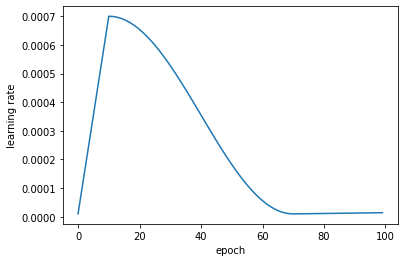

In [ ]:
def lr_schedule(epoch):
    """
    学習率cosineアニーリング
    """

    if epoch <= Config.begining:
        return Config.lr_base + epoch * (Config.lr_max - Config.lr_base) / Config.begining        
    elif (epoch > Config.begining) and (epoch <= Config.ending):
        value = np.cos(np.pi * (epoch - Config.begining) / (Config.ending - Config.begining)) + 1
        return value * (Config.lr_max - Config.lr_base) / 2 + Config.lr_base
    else:
        return (epoch - Config.epochs) * (Config.lr_min - Config.lr_base) / (Config.epochs - Config.ending)

def lr_graph():
    """
    学習率のグラフを表示
    """
    from matplotlib import pyplot as plt

    epoch_point = [i for i in range(100)]
    lr_point = [lr_schedule(i) for i in range(100)]
    plt.plot(epoch_point, lr_point)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")

lr_graph()

## 5.2 model準備
訓練するmodelを構築する関数を定義します。

In [ ]:
def get_pretrained_model():
    """
    使用する事前学習されたmodelを取得する。
    """
    if Config.model=="efn_b4":
        pretrained_model = efn.EfficientNetB4(
            weights=Config.weights, 
            include_top=False)
        
    elif Config.model=="efn_b7":
        pretrained_model = efn.EfficientNetB7(
            weights=Config.weights, 
            include_top=False)
    
    elif "v2" in Config.model:
        pretrained_model = hub.KerasLayer(hub_url)

    pretrained_model.trainable = True

    return pretrained_model


def build_model():
    """
    modelの全体構造を定義する。
    """
    pretrained_model = get_pretrained_model()
    
    input = tf.keras.layers.Input(shape=(Config.image_size, Config.image_size, 3))
    x = pretrained_model(input)
    if "v2" not in Config.model:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    elif "v2" in Config.model:
        x = tf.keras.layers.Dropout(rate=0.2)(x)
    pred = tf.keras.layers.Dense(Config.n_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input, outputs=pred)
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=categorical_focal_loss(alpha=1), 
                  metrics=['accuracy'])
    
    return model

In [ ]:
def get_model():
    """
    modelを実行環境下で取得する。
    """
    if TPU:
        tf.config.experimental_connect_to_cluster(TPU)
        tf.tpu.experimental.initialize_tpu_system(TPU)
        tpu_strategy = tf.distribute.TPUStrategy(TPU)
        with tpu_strategy.scope():
            model = build_model()
    else:
        model = build_model()

    return model

## 5.3 訓練関数
訓練の手順を定義します。

In [ ]:
def train_cv():
    """
    交差検証関数(訓練)
    """
    # 訓練状況を記録するdictionary
    try:
        # 訓練途中であれば引継ぐ
        with open(os.path.join(MODEL, "status.json"), mode="r") as f:
            status = json.load(f)       
    except:
        # 新規作成
        time_jp = datetime.datetime.now() + datetime.timedelta(hours=9)
        time_jp = time_jp.strftime("%m%d%H%M")
        status = {"fold": [],
                  "seed": Config.seed,
                  "time_jp": time_jp,
                  "model_path" : [],
                  "model_name" : Config.model,
                  "image_size" : Config.image_size,
                  "val_accuracy": [],
                  "val_loss": []}
    
    # 訓練ファイルのpathとラベルを取得
    filepaths, labels = get_train_data()

    # 交差検証
    for i_fold, (tr_idx, val_idx) in enumerate(skf(filepaths, np.argmax(labels, axis=1))):
        K.clear_session()
        
        print(f"\n##### FOLD {i_fold+1} #####\n")
        model_name = f"model{status['time_jp']}_fold{i_fold+1}"
        model_path = os.path.join(MODEL, f"{model_name}.h5")

        # 保存したモデルがある場合訓練をスキップ
        if os.path.exists(model_path):
            continue


        # 少ないラベルのデータ複製
        if Config.copy:
            tr_idx = copy_few_data(tr_idx, labels)

        tr_filepaths, tr_labels = filepaths[tr_idx], labels[tr_idx]
        val_filepaths, val_labels = filepaths[val_idx], labels[val_idx]
        
        # 訓練データに擬似ラベルデータを加える
        if Config.pseudo:
            tr_filepaths, tr_labels = concat_pseudo(tr_filepaths, tr_labels)

        # callbacks
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path, 
            monitor=Config.best_monitor, 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=True
            )
        stop_cb = tf.keras.callbacks.EarlyStopping(
            monitor=Config.stop_monitor, 
            patience=Config.patience, 
            verbose=1, 
            mode='auto'
            )
        lr_cb = tf.keras.callbacks.LearningRateScheduler(
            lr_schedule, 
            verbose=True
            )

        # tf.data.Dataset準備
        image_processor = ImageProcessor(Config.num_ops, 
                                         Config.magnitude, 
                                         Config.image_size)
        tr_ds = image_processor.rand_aug_dataset(tr_filepaths, 
                                                 tr_labels)
        val_ds = image_processor.val_dataset(val_filepaths, 
                                             val_labels) 

        # 訓練実行
        model = get_model()
        history = model.fit(
            tr_ds,
            validation_data=val_ds,
            steps_per_epoch=len(tr_idx)//Config.batch_size,
            validation_steps=len(val_idx)//Config.batch_size,
            epochs=Config.epochs,
            verbose=1,
            callbacks=[stop_cb, lr_cb, checkpoint_cb]
            )
        
        # fold毎の記録
        history_df = pd.DataFrame(history.history)
        history_df.to_csv(os.path.join(MODEL, f"history-{model_name}.csv"), 
                          index=False)

        status["val_accuracy"].append(max(history.history['val_accuracy']))
        status["val_loss"].append(min(history.history['val_loss']))
        status["fold"].append(i_fold)
        status["model_path"].append(model_path)

        print(f"\n{status}\n")
        with open(os.path.join(MODEL, "status.json"), mode="w") as f:
            json.dump(status, f)

    return status

## 5.4 記録
学習結果を記録し、json形式で保存します。

In [ ]:
def record_total_result(status):
    """
    訓練全体の結果とハイパーパラメータとモデルの構造を記録する。
    """
    val_acc_list = status["val_accuracy"]
    val_loss_list = status["val_loss"]
    time_jp = status["time_jp"]
    model_path = status["model_path"]
  
    # 訓練が完了した場合、dictionaryを個別化して保存
    with open(os.path.join(RECORD, f"record{time_jp}.json"), mode="w") as f:
        json.dump(status, f)

    # notebookのコードを呼び出す
    with open(os.path.join(DRIVE, "religious_art_train.ipynb"), "r") as f:
        code = f.read()

    # ハイパーパラメータとモデル構造のセルを抽出し記録
    code_text = ""
    for i in [14, 31]:
        code_text += "".join(json.loads(code)["cells"][i]["source"])+"\n\n\n"

    with open(os.path.join(MODEL, f"model{time_jp}conf_result.txt"), "w") as f:
        f.write(
            f"{model_path}\n"
            f"seed : {Config.seed}\n"
            f"val acc: {val_acc_list},\n mean: {np.mean(val_acc_list)}\n"
            f"val loss: {val_loss_list},\n mean: {np.mean(val_loss_list)}\n"
            f"CODE: \n{code_text}"
            )

# 6.実行

In [ ]:
def main():
    status = train_cv()
    record_total_result(status)

In [ ]:
main()


##### FOLD 1 #####

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


258080768/258068648 [==============================] - 2s 0us/step

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


20/20 [==============================] - ETA: 0s - loss: 2.1921 - accuracy: 0.0969
Epoch 00001: val_accuracy improved from -inf to 0.07187, saving model to /content/drive/MyDrive/portforio/religious_art/model/efn_b7-600/model11141537_fold1.h5
20/20 [==============================] - 282s 3s/step - loss: 2.1921 - accuracy: 0.0969 - val_loss: 2.2098 - val_accuracy: 0.0719 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 7.9e-05.
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 2.1452 - accuracy: 0.1406
Epoch 00002: val_accuracy improved from 0.07187 to 0.09063, saving model to /content/drive/MyDrive/portforio/religious_art/model/efn_b7-600/model11141537_fold1.h5
20/20 [==============================] - 24s 1s/step - loss: 2.1452 - accuracy: 0.1406 - val_loss: 2.2131 - val_accuracy: 0.0906 - lr: 7.9000e-05

{'fold': [0], 'seed': 21, 'time_jp': '11141537', 'model_path': ['/content/drive/MyDrive/portforio/religious_art/model/efn_b7-600/model111

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)



Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2
21/21 [==============================] - ETA: 0s - loss: 2.2514 - accuracy: 0.0595
Epoch 00001: val_accuracy improved from -inf to 0.07812, saving model to /content/drive/MyDrive/portforio/religious_art/model/efn_b7-600/model11141537_fold2.h5
21/21 [==============================] - 279s 2s/step - loss: 2.2514 - accuracy: 0.0595 - val_loss: 2.2070 - val_accuracy: 0.0781 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 7.9e-05.
Epoch 2/2
21/21 [==============================] - ETA: 0s - loss: 2.1715 - accuracy: 0.1280
Epoch 00002: val_accuracy did not improve from 0.07812
21/21 [==============================] - 18s 860ms/step - loss: 2.1715 - accuracy: 0.1280 - val_loss: 2.1990 - val_accuracy: 0.0531 - lr: 7.9000e-05

{'fold': [0, 1], 'seed': 21, 'time_jp': '11141537', 'model_path': ['/content/drive/MyDrive/portforio/religious_art/model/efn_b7-600/model11141537_fold1.h5', '/conte